In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from snorkel import SnorkelSession
session = SnorkelSession()

import os
from snorkel.parser import XMLMultiDocPreprocessor

# The following line is for testing only. Feel free to ignore it.

file_path = 'articles/training.xml'
train_preprocessor = XMLMultiDocPreprocessor(
    path=file_path,
    doc='.//article',
    text='.//front/article-meta/abstract/p/text()',
    id=  './/front/article-meta/article-id/text()'
)

file_path = 'articles/development.xml'
dev_preprocessor = XMLMultiDocPreprocessor(
    path=file_path,    
    doc='.//document',    
    text='.//passage/text/text()',    
    id='.//id/text()'
)

file_path = 'articles/testcorpus.xml'
test_preprocessor = XMLMultiDocPreprocessor(
    path=file_path,    
    doc='.//document',    
    text='.//passage/text/text()',    
    id='.//id/text()'
)

In [ ]:
from snorkel.parser import CorpusParser

corpus_parser = CorpusParser()
corpus_parser.apply(list(train_preprocessor)) #parallelism can be run with a Postgres DBMS, but not SQLite
corpus_parser.apply(list(dev_preprocessor), clear=False)
corpus_parser.apply(list(test_preprocessor), clear=False)

from playsound import *
playsound('ding.mp3')

In [ ]:
from six.moves.cPickle import load
from snorkel.models import Document, Sentence
import cPickle

with open('articles/doc_ids.pkl', 'rb') as f:
    train_ids, dev_ids, test_ids = load(f)
train_ids, dev_ids, test_ids = set(train_ids), set(dev_ids), set(test_ids)
print len(train_ids)
print len(dev_ids)
print len(test_ids)
train_sents, dev_sents, test_sents = set(), set(), set()
docs = session.query(Document).order_by(Document.name).all()
print docs
print len(docs)
for i, doc in enumerate(docs):
    for s in doc.sentences:
        if doc.name in train_ids:
            train_sents.add(s)
        elif doc.name in dev_ids:
            dev_sents.add(s)
        elif doc.name in test_ids:
            test_sents.add(s)
        else:
            raise Exception('ID <{0}> not found in any id set'.format(doc.name))

In [ ]:
from snorkel.models import Candidate, candidate_subclass

BiomarkerDrug = candidate_subclass('BiomarkerDrug', ['biomarker', 'drug'])

from snorkel.models import candidate_subclass
from snorkel.candidates import Ngrams, CandidateExtractor
from snorkel.matchers import PersonMatcher
import matchers
from snorkel.models import Document
from snorkel.viewer import SentenceNgramViewer
import os

biomarker_ngrams = Ngrams(n_max=1)
drug_ngrams = Ngrams(n_max=5)

# Create our two Matchers
bMatcher = matchers.getBiomarkerMatcher()
dMatcher = matchers.getDrugMatcher()
    
# Building the CandidateExtractor 
candidate_extractor = CandidateExtractor(BiomarkerDrug, [biomarker_ngrams, drug_ngrams], [bMatcher, dMatcher])


In [ ]:
for k, sents in enumerate([train_sents, dev_sents, test_sents]):
    candidate_extractor.apply(sents, split=k)
    print("Number of candidates:", session.query(BiomarkerDrug).filter(BiomarkerDrug.split == k).count())
dev_cands = session.query(BiomarkerDrug).filter(BiomarkerDrug.split == 1).all()
for c in dev_cands:
    print c

In [21]:
from candidate_adjective_fixer_drug import *
add_adj_candidate(session, BiomarkerDrug, dev_cands)
session.commit()

 added to Orlistat
 added to Orlistat
 added to cisplatin
 added to bleomycin
 added to bleomycin
 added to bleomycin
 added to bleomycin
 added to decitabine
 added to decitabine
 added to tryptophan
 added to ubiquinone
 added to ubiquinone
 added to sorafenib
 added to sorafenib
 added to sorafenib
 added to sorafenib
 added to sorafenib
 added to sorafenib
 added to sorafenib
 added to sorafenib
 added to sorafenib
 added to sorafenib
 added to sorafenib
 added to pimonidazole
 added to pimonidazole
mg/kg  added to selenium
Checking Biomarker: 28262851::span:755:756
Checking Condition: 28262851::span:276:289
1
 added to cholesterol
mg/kg  added to selenium
Checking Biomarker: 28262851::span:755:756
Checking Condition: 28262851::span:218:231
1
mg/kg  added to selenium
Checking Biomarker: 28262851::span:697:698
Checking Condition: 28262851::span:276:289
1
 added to cholesterol
mg/kg  added to selenium
Checking Biomarker: 28262851::span:697:698
Checking Condition: 28262851::span:218:2

 added to pre-treatment plasma fibrinogen
 added to c-mannosyl tryptophan
 added to prospective paroxetine
 added to human chorionic gonadotropin
 added to mmol/L ascorbic acid
 added to estrogenic hormone estradiol
Finished Processing Existing Candidates


In [ ]:
import re
#from snorkel.lf_terms import *
from snorkel.lf_helpers import  *
from snorkel.lf_helpers import get_sent_candidate_spans
from snorkel.lf_helpers import get_left_tokens, get_right_tokens
from random import randint
import cPickle
import unicodedata
from PyDictionary import PyDictionary
sentence_keyword_lemmas = ["contain", "collect", "find", "sample", "fluid", "tissue", "detection"]
sentences = []

knowAbbreviations = []
with open('databases/abbreviations.com.pkl', 'rb') as f:
    knowAbbreviations = cPickle.load(f)

#2 - if the word has a colon after it its generally not a biomarker
def LF_colon(c):
    words_in_between = []
    for thing in get_between_tokens(c):
        words_in_between.append(thing)
    if(len(words_in_between) > 1 and words_in_between[0] == ":"):
        return -1

def LF_known_abs(c):
    if(c.biomarker.get_span() in knowAbbreviations):
        return -1

def LF_single_letter(c):
    if(len(c.biomarker.get_span()) < 2):
        return -1
    else:
        return 0
def LF_roman_numeral(c):
    biomarker = (c.biomarker.get_span())
    unicodedata.normalize('NFKD', biomarker).encode('ascii','ignore')
    if re.match(r'((?<=\s)|(?<=^))(M{1,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})|M{0,4}(CM|CD|D?C{1,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})|M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{1,3})(IX|IV|V?I{0,3})|M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{1,3}))(?=\s)',
                biomarker):
        return -1
    
with open('databases/common2000.pkl', 'rb') as f:
    common2000 = cPickle.load(f)

def LF_common_2000(c):
    if(c.biomarker.get_span() in common2000):
        return -1
def LF_same_thing(c):
    if(c.biomarker.get_span() == c.drug.get_span()):
        return -1

In [ ]:
LFs = [LF_colon, LF_known_abs, LF_single_letter, LF_roman_numeral, LF_common_2000, LF_same_thing]

In [ ]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

In [10]:
%time L_train = labeler.apply(split=0)
L_train

Clearing existing...
Running UDF...
[========================================] 100%%

CPU times: user 8.44 s, sys: 96 ms, total: 8.54 s
Wall time: 9.14 s


<813x6 sparse matrix of type '<type 'numpy.int64'>'
	with 56 stored elements in Compressed Sparse Row format>

In [11]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_colon,0,0.00123,0.0,0.0
LF_known_abs,1,0.03690,0.0,0.0
LF_single_letter,2,0.02829,0.0,0.0
LF_roman_numeral,3,0.00000,0.0,0.0
LF_common_2000,4,0.00000,0.0,0.0
LF_same_thing,5,0.00246,0.0,0.0


In [12]:
from snorkel.learning.structure import DependencySelector
ds = DependencySelector()
deps = ds.select(L_train, threshold=0.1)
len(deps)

15

In [13]:
deps

{(0, 1, 0),
 (0, 2, 0),
 (0, 3, 0),
 (0, 4, 0),
 (0, 5, 0),
 (1, 2, 0),
 (1, 3, 0),
 (1, 4, 0),
 (1, 5, 0),
 (2, 3, 0),
 (2, 4, 0),
 (2, 5, 0),
 (3, 4, 0),
 (3, 5, 0),
 (4, 5, 0)}

In [14]:
deps = set()

In [15]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel(lf_propensity=True)
gen_model.train(
    L_train, deps=deps, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=0.0
)

Inferred cardinality: 2


In [16]:
train_marginals = gen_model.marginals(L_train)

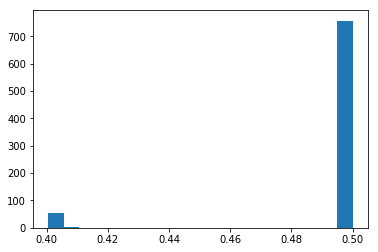

In [17]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [18]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.600089,0.4486,0.597496,0.269681
1,0.591913,0.4575,0.582465,0.270892
2,0.606790,0.4654,0.604891,0.284618
3,0.589920,0.4504,0.581112,0.259588
4,0.587768,0.4529,0.588000,0.267057
5,0.607790,0.4467,0.607939,0.275131


In [19]:
from snorkel.annotations import save_marginals
save_marginals(session, L_train, train_marginals)

Saved 813 marginals


In [22]:
from load_external_annotations_new import load_external_labels
load_external_labels(session, BiomarkerDrug, 'Biomarker', 'Drug', 'articles/drug_gold_labels.tsv', dev_cands, annotator_name='gold')

28260907::span:1204:1214
BiomarkerDrug(Span("adiponectin", sentence=14787, chars=[159,169], words=[36,36]), Span("Orlistat", sentence=14787, chars=[0,7], words=[0,0]))
28260907::span:1143:1151
BiomarkerDrug(Span("periostin", sentence=14787, chars=[98,106], words=[19,19]), Span("Orlistat", sentence=14787, chars=[0,7], words=[0,0]))
28261346::span:774:780
BiomarkerDrug(Span("GOLPH3L", sentence=14498, chars=[85,91], words=[13,13]), Span("cisplatin", sentence=14498, chars=[63,71], words=[10,10]))
28263294::span:714:719
BiomarkerDrug(Span("LTBP-4", sentence=13733, chars=[153,158], words=[25,25]), Span("bleomycin", sentence=13733, chars=[32,40], words=[5,5]))
28263294::span:604:606
BiomarkerDrug(Span("BLM", sentence=13733, chars=[43,45], words=[7,7]), Span("bleomycin", sentence=13733, chars=[32,40], words=[5,5]))
28263294::span:629:634
BiomarkerDrug(Span("LTBP-4", sentence=13733, chars=[68,73], words=[11,11]), Span("bleomycin", sentence=13733, chars=[32,40], words=[5,5]))
28263294::span:771:

28260907::span:301:305
BiomarkerDrug(Span("NAFLD", sentence=14781, chars=[37,41], words=[6,6]), Span("orlistat", sentence=14781, chars=[25,32], words=[4,4]))
28260907::span:537:541
BiomarkerDrug(Span("NAFLD", sentence=14783, chars=[94,98], words=[16,16]), Span("orlistat", sentence=14783, chars=[65,72], words=[11,11]))
28260907::span:612:616
BiomarkerDrug(Span("NAFLD", sentence=14784, chars=[68,72], words=[10,10]), Span("orlistat", sentence=14784, chars=[99,106], words=[18,18]))
28260907::span:1563:1573
BiomarkerDrug(Span("adiponectin", sentence=14789, chars=[180,190], words=[38,38]), Span("orlistat", sentence=14789, chars=[7,14], words=[2,2]))
28260907::span:1529:1537
BiomarkerDrug(Span("periostin", sentence=14789, chars=[146,154], words=[27,27]), Span("orlistat", sentence=14789, chars=[7,14], words=[2,2]))
28263001::span:1512:1513
BiomarkerDrug(Span("CI", sentence=13833, chars=[227,228], words=[55,55]), Span("BMD", sentence=13833, chars=[198,200], words=[47,47]))
28263001::span:1285:1

28262197::span:110:119
BiomarkerDrug(Span("BACKGROUND", sentence=14164, chars=[0,9], words=[0,0]), Span("iron", sentence=14164, chars=[141,144], words=[23,23]))
28262197::span:110:119
BiomarkerDrug(Span("BACKGROUND", sentence=14164, chars=[0,9], words=[0,0]), Span("iron", sentence=14164, chars=[186,189], words=[29,29]))
28262197::span:110:119
BiomarkerDrug(Span("BACKGROUND", sentence=14164, chars=[0,9], words=[0,0]), Span("iron", sentence=14164, chars=[87,90], words=[15,15]))
28262197::span:1697:1706
BiomarkerDrug(Span("CONCLUSION", sentence=14175, chars=[0,9], words=[0,0]), Span("iron", sentence=14175, chars=[91,94], words=[12,12]))
28262197::span:1697:1706
BiomarkerDrug(Span("CONCLUSION", sentence=14175, chars=[0,9], words=[0,0]), Span("iron", sentence=14175, chars=[67,70], words=[9,9]))
28261974::span:91:93
BiomarkerDrug(Span("AIM", sentence=14218, chars=[0,2], words=[0,0]), Span("colchicine", sentence=14218, chars=[37,46], words=[7,7]))
28261974::span:441:444
BiomarkerDrug(Span("CO

28260391::span:1499:1501
BiomarkerDrug(Span("HIV", sentence=15008, chars=[127,129], words=[17,17]), Span("tenofovir", sentence=15008, chars=[149,157], words=[21,21]))
28260162::span:108:114
BiomarkerDrug(Span("PURPOSE", sentence=15041, chars=[0,6], words=[0,0]), Span("sorafenib", sentence=15041, chars=[55,63], words=[8,8]))
28260162::span:108:114
BiomarkerDrug(Span("PURPOSE", sentence=15041, chars=[0,6], words=[0,0]), Span("sunitinib", sentence=15041, chars=[41,49], words=[6,6]))
28260162::span:1553:1563
BiomarkerDrug(Span("CONCLUSIONS", sentence=15052, chars=[0,10], words=[0,0]), Span("sunitinib", sentence=15052, chars=[167,175], words=[27,27]))
28260162::span:1553:1563
BiomarkerDrug(Span("CONCLUSIONS", sentence=15052, chars=[0,10], words=[0,0]), Span("sorafenib", sentence=15052, chars=[181,189], words=[29,29]))
28263514::span:277:280
BiomarkerDrug(Span("TNBS", sentence=13618, chars=[115,118], words=[17,17]), Span("pentoxifylline", sentence=13618, chars=[66,79], words=[11,11]))
282635

28263535::span:1410:1416
BiomarkerDrug(Span("CYP2C11", sentence=13577, chars=[17,23], words=[3,3]), Span("testosterone", sentence=13577, chars=[112,123], words=[20,20]))
28263535::span:1596:1601
BiomarkerDrug(Span("CYP2C6", sentence=13578, chars=[59,64], words=[11,11]), Span("diclofenac", sentence=13578, chars=[67,76], words=[13,13]))
28263535::span:1759:1761
BiomarkerDrug(Span("EE2", sentence=13579, chars=[100,102], words=[16,16]), Span("estradiol", sentence=13579, chars=[108,116], words=[18,18]))
28263535::span:1663:1669
BiomarkerDrug(Span("CYP2C11", sentence=13579, chars=[4,10], words=[1,1]), Span("estradiol", sentence=13579, chars=[108,116], words=[18,18]))
28263535::span:1896:1898
BiomarkerDrug(Span("EE2", sentence=13580, chars=[63,65], words=[11,11]), Span("estradiol", sentence=13580, chars=[71,79], words=[13,13]))
28263535::span:1837:1842
BiomarkerDrug(Span("CYP2C6", sentence=13580, chars=[4,9], words=[1,1]), Span("estradiol", sentence=13580, chars=[71,79], words=[13,13]))
28263

[]
AnnotatorLabels created: 0


In [23]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_dev

<265x1 sparse matrix of type '<type 'numpy.int64'>'
	with 249 stored elements in Compressed Sparse Row format>

In [24]:
L_dev = labeler.apply_existing(split=1)
_ = gen_model.score(session, L_dev, L_gold_dev)

Clearing existing...
Running UDF...
[========================================] 100%%

Scores (Un-adjusted)
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 249 | FN: 16



In [27]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_colon,0,0.124528,0.0,0.0,0,0,0,29,1.0,NaN
LF_known_abs,1,0.007547,0.0,0.0,0,0,0,2,1.0,NaN
LF_single_letter,2,0.000000,0.0,0.0,0,0,0,0,NaN,NaN
LF_roman_numeral,3,0.000000,0.0,0.0,0,0,0,0,NaN,NaN
LF_common_2000,4,0.000000,0.0,0.0,0,0,0,0,NaN,NaN
LF_same_thing,5,0.000000,0.0,0.0,0,0,0,0,NaN,NaN


In [ ]:
import numpy as np

# Load dev labels and convert to [0, 1] range
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
dev_labels = (np.ravel(L_gold_dev.todense()) + 1) / 2

In [ ]:
from snorkel.annotations import FeatureAnnotator
featurizer = FeatureAnnotator()

%time F_train = featurizer.apply(split=0)
F_train

In [ ]:
%%time
F_dev  = featurizer.apply_existing(split=1)
F_test = featurizer.apply_existing(split=2)

In [ ]:
from snorkel.annotations import load_marginals
train_marginals = load_marginals(session, F_train, split=0)

In [ ]:
from snorkel.learning import SparseLogisticRegression
disc_model = SparseLogisticRegression()

In [ ]:
from snorkel.learning.utils import MentionScorer
from snorkel.learning import RandomSearch, ListParameter, RangeParameter

# Searching over learning rate
rate_param = RangeParameter('lr', 1e-6, 1e-2, step=1, log_base=10)
l1_param  = RangeParameter('l1_penalty', 1e-6, 1e-2, step=1, log_base=10)
l2_param  = RangeParameter('l2_penalty', 1e-6, 1e-2, step=1, log_base=10)

searcher = RandomSearch(session, disc_model, F_train, train_marginals, [rate_param, l1_param, l2_param], n=20)

In [ ]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_dev

import numpy as np
np.random.seed(1701)
searcher.fit(F_dev, L_gold_dev, n_epochs=50, rebalance=0.5, print_freq=25)

#

In [ ]:
test_cands = session.query(BiomarkerDrug).filter(BiomarkerDrug.split == 2).all()
train_cands = session.query(BiomarkerDrug).filter(BiomarkerDrug.split == 0).all()

In [ ]:
from load_external_annotations_new import load_external_labels
load_external_labels(session, BiomarkerMedium, 'Biomarker', 'Medium', 'articles/medium_test_labels.tsv', test_cands, annotator_name='gold')

from snorkel.annotations import load_gold_labels
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)
L_gold_test

tp, fp, tn, fn = disc_model.score(session, F_test, L_gold_test)

In [ ]:
print fp

In [ ]:
from snorkel.contrib.rnn import reRNN

train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   50,
    'dropout':    0.5,
    'rebalance':  0.25,
    'print_freq': 5
}

lstm = reRNN(seed=1701, n_threads=None)
lstm.train(train, train_marginals, dev_candidates=dev, dev_labels=dev_labels, **train_kwargs)

In [ ]:
lstm.save("biomarkerdrug.lstm")